# Fit logistic regression model

- based on different imputation methods
- baseline: reference
- model: any other selected imputation method

In [1]:
import logging
from pathlib import Path
from typing import List

import matplotlib.pyplot as plt
import njab.sklearn
import pandas as pd
import sklearn
from njab.plotting.metrics import plot_split_auc, plot_split_prc
from njab.sklearn.types import Splits

import pimmslearn
import pimmslearn.analyzers
import pimmslearn.io.datasplits

plt.rcParams['figure.figsize'] = (2.5, 2.5)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 2
fontsize = 5
figsize = (2.5, 2.5)
pimmslearn.plotting.make_large_descriptors(fontsize)


logger = pimmslearn.logging.setup_nb_logger()
logging.getLogger('fontTools').setLevel(logging.ERROR)


def parse_roc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _roc = (pd.DataFrame(_r.test.roc,
                             index='fpr tpr cutoffs'.split()
                             )).loc[['fpr', 'tpr']]
        _roc = _roc.T
        _roc.columns = pd.MultiIndex.from_product([[_r.name], _roc.columns])
        ret.append(_roc)
    ret = pd.concat(ret, axis=1)
    return ret


def parse_prc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _prc = pd.DataFrame(_r.test.prc,
                            index='precision recall cutoffs'.split()
                            ).loc[['precision', 'recall']]
        _prc = _prc.T.rename(columns={'recall': 'tpr'})
        _prc.columns = pd.MultiIndex.from_product([[_r.name], _prc.columns])
        ret.append(_prc)
    ret = pd.concat(ret, axis=1)
    return ret


# catch passed parameters
args = None
args = dict(globals()).keys()

## Parameters
Default and set parameters for the notebook.

In [2]:
folder_data: str = ''  # specify data directory if needed
fn_clinical_data = "data/ALD_study/processed/ald_metadata_cli.csv"
folder_experiment = "runs/appl_ald_data/plasma/proteinGroups"
model_key = 'VAE'
target = 'kleiner'
sample_id_col = 'Sample ID'
cutoff_target: int = 2  # => for binarization target >= cutoff_target
file_format = "csv"
out_folder = 'diff_analysis'
fn_qc_samples = ''  # 'data/ALD_study/processed/qc_plasma_proteinGroups.pkl'

baseline = 'RSN'  # default is RSN, as this was used in the original ALD Niu. et. al 2022
template_pred = 'pred_real_na_{}.csv'  # fixed, do not change

In [3]:
# Parameters
cutoff_target = 0.5
folder_experiment = "runs/alzheimer_study"
target = "AD"
baseline = "PI"
model_key = "CF"
out_folder = "diff_analysis"
fn_clinical_data = "runs/alzheimer_study/data/clinical_data.csv"


In [4]:
params = pimmslearn.nb.get_params(args, globals=globals())
args = pimmslearn.nb.Config()
args.folder_experiment = Path(params["folder_experiment"])
args = pimmslearn.nb.add_default_paths(args,
                                 out_root=(args.folder_experiment
                                           / params["out_folder"]
                                           / params["target"]
                                           / f"{params['baseline']}_vs_{params['model_key']}"))
args.update_from_dict(params)
files_out = dict()
args

root - INFO     Removed from global namespace: folder_data


root - INFO     Removed from global namespace: fn_clinical_data


root - INFO     Removed from global namespace: folder_experiment


root - INFO     Removed from global namespace: model_key


root - INFO     Removed from global namespace: target


root - INFO     Removed from global namespace: sample_id_col


root - INFO     Removed from global namespace: cutoff_target


root - INFO     Removed from global namespace: file_format


root - INFO     Removed from global namespace: out_folder


root - INFO     Removed from global namespace: fn_qc_samples


root - INFO     Removed from global namespace: baseline


root - INFO     Removed from global namespace: template_pred


root - INFO     Already set attribute: folder_experiment has value runs/alzheimer_study


root - INFO     Already set attribute: out_folder has value diff_analysis


{'baseline': 'PI',
 'cutoff_target': 0.5,
 'data': PosixPath('runs/alzheimer_study/data'),
 'file_format': 'csv',
 'fn_clinical_data': 'runs/alzheimer_study/data/clinical_data.csv',
 'fn_qc_samples': '',
 'folder_data': '',
 'folder_experiment': PosixPath('runs/alzheimer_study'),
 'model_key': 'CF',
 'out_figures': PosixPath('runs/alzheimer_study/figures'),
 'out_folder': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF'),
 'out_metrics': PosixPath('runs/alzheimer_study'),
 'out_models': PosixPath('runs/alzheimer_study'),
 'out_preds': PosixPath('runs/alzheimer_study/preds'),
 'sample_id_col': 'Sample ID',
 'target': 'AD',
 'template_pred': 'pred_real_na_{}.csv'}

## Load data

### Load target

In [5]:
target = pd.read_csv(args.fn_clinical_data,
                     index_col=0,
                     usecols=[args.sample_id_col, args.target])
target = target.dropna()
target

,AD
Sample ID,
Sample_000,0
Sample_001,1
Sample_002,1
Sample_003,1
Sample_004,1
...,...
Sample_205,1
Sample_206,0
Sample_207,0


### MS proteomics or specified omics data
Aggregated from data splits of the imputation workflow run before.

In [6]:
data = pimmslearn.io.datasplits.DataSplits.from_folder(
    args.data, file_format=args.file_format)
data = pd.concat([data.train_X, data.val_y, data.test_y])
data.sample(5)

pimmslearn.io.datasplits - INFO     Loaded 'train_X' from file: runs/alzheimer_study/data/train_X.csv


pimmslearn.io.datasplits - INFO     Loaded 'val_y' from file: runs/alzheimer_study/data/val_y.csv


pimmslearn.io.datasplits - INFO     Loaded 'test_y' from file: runs/alzheimer_study/data/test_y.csv


Sample ID   protein groups                                                
Sample_098  Q9GZP4;Q9GZP4-2                                                  16.252
Sample_003  P55290;P55290-4                                                  19.966
Sample_078  A0A0U1RR20;Q92954;Q92954-2;Q92954-3;Q92954-4;Q92954-5;Q92954-6   16.678
Sample_083  Q9Y5F6;Q9Y5F6-2                                                  15.344
Sample_046  A0A075B7B8                                                       16.147
Name: intensity, dtype: float64

Get overlap between independent features and target

### Select by ALD criteria
Use parameters as specified in [ALD study](https://github.com/RasmussenLab/pimms/tree/main/project/data/ALD_study).

In [7]:
DATA_COMPLETENESS = 0.6
MIN_N_PROTEIN_GROUPS: int = 200
FRAC_PROTEIN_GROUPS: int = 0.622
CV_QC_SAMPLE: float = 0.4

ald_study, cutoffs = pimmslearn.analyzers.diff_analysis.select_raw_data(data.unstack(
), data_completeness=DATA_COMPLETENESS, frac_protein_groups=FRAC_PROTEIN_GROUPS)

if args.fn_qc_samples:
    qc_samples = pd.read_pickle(args.fn_qc_samples)
    qc_samples = qc_samples[ald_study.columns]
    qc_cv_feat = qc_samples.std() / qc_samples.mean()
    qc_cv_feat = qc_cv_feat.rename(qc_samples.columns.name)
    fig, ax = plt.subplots(figsize=(4, 7))
    ax = qc_cv_feat.plot.box(ax=ax)
    ax.set_ylabel('Coefficient of Variation')
    print((qc_cv_feat < CV_QC_SAMPLE).value_counts())
    ald_study = ald_study[pimmslearn.analyzers.diff_analysis.select_feat(qc_samples)]

column_name_first_prot_to_pg = {
    pg.split(';')[0]: pg for pg in data.unstack().columns}

ald_study = ald_study.rename(columns=column_name_first_prot_to_pg)
ald_study

root - INFO     Initally: N samples: 210, M feat: 1421


root - INFO     Dropped features quantified in less than 126 samples.


root - INFO     After feat selection: N samples: 210, M feat: 1213


root - INFO     Min No. of Protein-Groups in single sample: 754


root - INFO     Finally: N samples: 210, M feat: 1213


protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,NaN,...,16.012,15.178,NaN,15.050,16.842,19.863,NaN,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,NaN,19.067,16.188,...,15.528,15.576,NaN,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,NaN,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,NaN,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,NaN,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,NaN,15.345,17.084,18.708,14.249,19.433,NaN,NaN
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Number of complete cases which can be used:

In [8]:
mask_has_target = data.index.levels[0].intersection(target.index)
assert not mask_has_target.empty, f"No data for target: {data.index.levels[0]} and {target.index}"
print(
    f"Samples available both in proteomics data and for target: {len(mask_has_target)}")
target, data, ald_study = target.loc[mask_has_target], data.loc[mask_has_target], ald_study.loc[mask_has_target]

Samples available both in proteomics data and for target: 210


### Load imputations from specified model

In [9]:
fname = args.out_preds / args.template_pred.format(args.model_key)
print(f"missing values pred. by {args.model_key}: {fname}")
load_single_csv_pred_file = pimmslearn.analyzers.compare_predictions.load_single_csv_pred_file
pred_real_na = load_single_csv_pred_file(fname).loc[mask_has_target]
pred_real_na.sample(3)

missing values pred. by CF: runs/alzheimer_study/preds/pred_real_na_CF.csv


Sample ID   protein groups               
Sample_203  Q96RW7;Q96RW7-2                 15.329
Sample_019  O76070                          13.646
Sample_151  A6H8L4;E7EUI5;P78536;P78536-2   14.397
Name: intensity, dtype: float64

### Load imputations from baseline model

In [10]:
fname = args.out_preds / args.template_pred.format(args.baseline)
pred_real_na_baseline = load_single_csv_pred_file(fname)  # .loc[mask_has_target]
pred_real_na_baseline

Sample ID   protein groups          
Sample_000  A0A075B6J9                 11.900
            A0A075B6Q5                 12.816
            A0A075B6R2                 13.155
            A0A075B6S5                 12.722
            A0A087WSY4                 12.928
                                        ...  
Sample_209  Q9P1W8;Q9P1W8-2;Q9P1W8-4   12.164
            Q9UI40;Q9UI40-2            12.192
            Q9UIW2                     13.120
            Q9UMX0;Q9UMX0-2;Q9UMX0-4   11.914
            Q9UP79                     13.848
Name: intensity, Length: 46401, dtype: float64

## Modeling setup
General approach:
  - use one train, test split of the data
  - select best 10 features from training data `X_train`, `y_train` before binarization of target
  - dichotomize (binarize) data into to groups (zero and 1)
  - evaluate model on the test data `X_test`, `y_test`

Repeat general approach for
 1. all original ald data: all features justed in original ALD study
 2. all model data: all features available my using the self supervised deep learning model
 3. newly available feat only: the subset of features available from the
    self supervised deep learning model which were newly retained using the
    new approach

All data:

In [11]:
X = pd.concat([data, pred_real_na]).unstack()
X

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H7,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,17.301,20.246,16.764,17.584,16.988,20.054,...,16.012,15.178,14.421,15.050,16.842,19.863,15.776,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,13.796,19.941,18.786,17.144,16.215,19.067,...,15.528,15.576,14.196,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,18.175,19.251,16.832,15.671,17.012,18.569,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,15.963,19.628,17.852,18.877,14.182,18.985,...,15.495,14.590,14.682,15.140,17.356,19.429,15.409,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,15.473,20.450,18.682,17.081,14.140,19.686,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,15.657,17.705,17.039,14.656,16.413,19.102,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,15.882,18.154,18.152,16.503,16.860,18.538,...,15.422,16.106,14.927,15.345,17.084,18.708,14.249,19.433,12.186,10.775
Sample_207,15.739,16.877,15.469,16.898,14.906,18.636,17.950,16.321,16.401,18.849,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


### Subset of data by ALD criteria

In [12]:
# could be just observed, drop columns with missing values
ald_study = pd.concat(
    [ald_study.stack(),
     pred_real_na_baseline.loc[
        # only select columns in selected in ald_study
        pd.IndexSlice[:, pred_real_na.index.levels[-1].intersection(ald_study.columns)]
    ]
    ]
).unstack()
ald_study

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6K4,...,O14793,O95479;R4GMU1,P01282;P01282-2,P10619;P10619-2;X6R5C5;X6R8A1,P21810,Q14956;Q14956-2,Q6ZMP0;Q6ZMP0-2,Q9HBW1,Q9NY15,P17050
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,16.148,...,14.010,12.558,13.568,12.760,12.508,11.884,12.687,14.098,12.767,11.431
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,10.274,19.067,16.127,...,12.952,13.277,12.289,12.327,12.490,13.212,11.061,12.919,12.837,13.489
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,15.387,...,12.570,14.309,13.537,13.696,13.149,13.673,12.183,12.705,13.089,12.239
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,16.565,...,13.252,12.758,13.050,12.294,12.250,12.862,12.129,12.347,11.923,12.663
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,16.418,...,11.670,12.736,12.399,13.237,12.638,13.105,13.582,14.324,13.172,13.326
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,13.270,16.413,19.102,15.350,...,14.269,14.064,16.826,18.182,15.225,15.044,14.192,16.605,14.995,14.257
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,16.582,...,14.273,17.700,16.802,20.202,15.280,15.086,13.978,18.086,15.557,14.171
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,15.768,...,14.473,16.882,16.917,20.105,15.690,15.135,13.138,17.066,15.706,15.690


Features which would not have been included using ALD criteria:

In [13]:
new_features = X.columns.difference(ald_study.columns)
new_features

Index(['A0A075B6H7', 'A0A075B6Q5', 'A0A075B7B8', 'A0A087WSY4',
       'A0A087WTT8;A0A0A0MQX5;O94779;O94779-2', 'A0A087WXB8;Q9Y274',
       'A0A087WXE9;E9PQ70;Q6UXH9;Q6UXH9-2;Q6UXH9-3',
       'A0A087X1Z2;C9JTV4;H0Y4Y4;Q8WYH2;Q96C19;Q9BUP0;Q9BUP0-2',
       'A0A0A0MQS9;A0A0A0MTC7;Q16363;Q16363-2', 'A0A0A0MSN4;P12821;P12821-2',
       ...
       'Q9NZ94;Q9NZ94-2;Q9NZ94-3', 'Q9NZU1', 'Q9P1W8;Q9P1W8-2;Q9P1W8-4',
       'Q9UHI8', 'Q9UI40;Q9UI40-2',
       'Q9UIB8;Q9UIB8-2;Q9UIB8-3;Q9UIB8-4;Q9UIB8-5;Q9UIB8-6',
       'Q9UKZ4;Q9UKZ4-2', 'Q9UMX0;Q9UMX0-2;Q9UMX0-4', 'Q9Y281;Q9Y281-3',
       'Q9Y490'],
      dtype='object', name='protein groups', length=208)

Binarize targets, but also keep groups for stratification

In [14]:
target_to_group = target.copy()
target = target >= args.cutoff_target
pd.crosstab(target.squeeze(), target_to_group.squeeze())

AD,0,1
AD,,
False,122,0
True,0,88


## Determine best number of parameters by cross validation procedure

using subset of data by ALD criteria:

In [15]:
cv_feat_ald = njab.sklearn.find_n_best_features(X=ald_study, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_ald = (cv_feat_ald
               .drop('test_case', axis=1)
               .groupby('n_features')
               .agg(['mean', 'std']))
cv_feat_ald

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 348.28it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  7.84it/s]

100%|██████████| 2/2 [00:00<00:00,  7.81it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  6.45it/s]

100%|██████████| 3/3 [00:00<00:00,  4.28it/s]

100%|██████████| 3/3 [00:00<00:00,  4.57it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  5.26it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  4.11it/s]

100%|██████████| 4/4 [00:00<00:00,  3.80it/s]

100%|██████████| 4/4 [00:00<00:00,  4.01it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00, 10.02it/s]

 80%|████████  | 4/5 [00:00<00:00,  5.40it/s]

100%|██████████| 5/5 [00:00<00:00,  4.87it/s]

100%|██████████| 5/5 [00:00<00:00,  5.30it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  6.15it/s]

 50%|█████     | 3/6 [00:00<00:00,  4.13it/s]

 67%|██████▋   | 4/6 [00:00<00:00,  3.77it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.57it/s]

100%|██████████| 6/6 [00:01<00:00,  3.33it/s]

100%|██████████| 6/6 [00:01<00:00,  3.67it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  5.97it/s]

 43%|████▎     | 3/7 [00:00<00:00,  4.74it/s]

 57%|█████▋    | 4/7 [00:00<00:00,  4.69it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  4.40it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  4.19it/s]

100%|██████████| 7/7 [00:01<00:00,  4.22it/s]

100%|██████████| 7/7 [00:01<00:00,  4.45it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:00,  7.76it/s]

 38%|███▊      | 3/8 [00:00<00:00,  5.71it/s]

 50%|█████     | 4/8 [00:00<00:00,  4.74it/s]

 62%|██████▎   | 5/8 [00:01<00:00,  4.40it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  3.53it/s]

 88%|████████▊ | 7/8 [00:01<00:00,  3.20it/s]

100%|██████████| 8/8 [00:02<00:00,  2.99it/s]

100%|██████████| 8/8 [00:02<00:00,  3.65it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  6.38it/s]

 33%|███▎      | 3/9 [00:00<00:01,  4.57it/s]

 44%|████▍     | 4/9 [00:00<00:01,  4.24it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  3.90it/s]

 67%|██████▋   | 6/9 [00:01<00:00,  3.95it/s]

 78%|███████▊  | 7/9 [00:01<00:00,  3.86it/s]

 89%|████████▉ | 8/9 [00:02<00:00,  3.57it/s]

100%|██████████| 9/9 [00:02<00:00,  3.43it/s]

100%|██████████| 9/9 [00:02<00:00,  3.85it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  7.77it/s]

 30%|███       | 3/10 [00:00<00:01,  5.73it/s]

 40%|████      | 4/10 [00:00<00:01,  4.14it/s]

 50%|█████     | 5/10 [00:01<00:01,  3.80it/s]

 60%|██████    | 6/10 [00:01<00:01,  3.71it/s]

 70%|███████   | 7/10 [00:01<00:00,  3.62it/s]

 80%|████████  | 8/10 [00:02<00:00,  3.46it/s]

 90%|█████████ | 9/10 [00:02<00:00,  3.54it/s]

100%|██████████| 10/10 [00:02<00:00,  3.56it/s]

100%|██████████| 10/10 [00:02<00:00,  3.86it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:00,  9.17it/s]

 27%|██▋       | 3/11 [00:00<00:01,  4.93it/s]

 36%|███▋      | 4/11 [00:00<00:01,  4.23it/s]

 45%|████▌     | 5/11 [00:01<00:01,  4.38it/s]

 55%|█████▍    | 6/11 [00:01<00:01,  4.20it/s]

 64%|██████▎   | 7/11 [00:01<00:00,  4.13it/s]

 73%|███████▎  | 8/11 [00:01<00:00,  4.26it/s]

 82%|████████▏ | 9/11 [00:02<00:00,  4.23it/s]

 91%|█████████ | 10/11 [00:02<00:00,  3.90it/s]

100%|██████████| 11/11 [00:02<00:00,  4.10it/s]

100%|██████████| 11/11 [00:02<00:00,  4.33it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  9.24it/s]

 25%|██▌       | 3/12 [00:00<00:01,  5.09it/s]

 33%|███▎      | 4/12 [00:00<00:01,  4.64it/s]

 42%|████▏     | 5/12 [00:00<00:01,  4.80it/s]

 50%|█████     | 6/12 [00:01<00:01,  5.19it/s]

 58%|█████▊    | 7/12 [00:01<00:00,  5.02it/s]

 67%|██████▋   | 8/12 [00:01<00:00,  4.77it/s]

 75%|███████▌  | 9/12 [00:01<00:00,  4.07it/s]

 83%|████████▎ | 10/12 [00:02<00:00,  4.12it/s]

 92%|█████████▏| 11/12 [00:02<00:00,  4.07it/s]

100%|██████████| 12/12 [00:02<00:00,  4.23it/s]

100%|██████████| 12/12 [00:02<00:00,  4.58it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:01,  6.80it/s]

 23%|██▎       | 3/13 [00:00<00:01,  5.35it/s]

 31%|███       | 4/13 [00:00<00:01,  4.81it/s]

 38%|███▊      | 5/13 [00:01<00:01,  4.69it/s]

 46%|████▌     | 6/13 [00:01<00:01,  4.70it/s]

 54%|█████▍    | 7/13 [00:01<00:01,  4.63it/s]

 62%|██████▏   | 8/13 [00:01<00:01,  4.66it/s]

 69%|██████▉   | 9/13 [00:01<00:00,  4.14it/s]

 77%|███████▋  | 10/13 [00:02<00:00,  4.31it/s]

 85%|████████▍ | 11/13 [00:02<00:00,  4.41it/s]

 92%|█████████▏| 12/13 [00:02<00:00,  4.27it/s]

100%|██████████| 13/13 [00:02<00:00,  4.28it/s]

100%|██████████| 13/13 [00:02<00:00,  4.54it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:01,  8.45it/s]

 21%|██▏       | 3/14 [00:00<00:01,  6.20it/s]

 29%|██▊       | 4/14 [00:00<00:01,  5.22it/s]

 36%|███▌      | 5/14 [00:00<00:01,  5.02it/s]

 43%|████▎     | 6/14 [00:01<00:01,  4.55it/s]

 50%|█████     | 7/14 [00:01<00:01,  4.56it/s]

 57%|█████▋    | 8/14 [00:01<00:01,  4.10it/s]

 64%|██████▍   | 9/14 [00:01<00:01,  4.08it/s]

 71%|███████▏  | 10/14 [00:02<00:00,  4.17it/s]

 79%|███████▊  | 11/14 [00:02<00:00,  4.19it/s]

 86%|████████▌ | 12/14 [00:02<00:00,  4.46it/s]

 93%|█████████▎| 13/14 [00:02<00:00,  4.41it/s]

100%|██████████| 14/14 [00:03<00:00,  4.37it/s]

100%|██████████| 14/14 [00:03<00:00,  4.57it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:01,  8.52it/s]

 20%|██        | 3/15 [00:00<00:02,  5.83it/s]

 27%|██▋       | 4/15 [00:00<00:02,  5.35it/s]

 33%|███▎      | 5/15 [00:00<00:02,  4.79it/s]

 40%|████      | 6/15 [00:01<00:02,  4.43it/s]

 47%|████▋     | 7/15 [00:01<00:01,  4.26it/s]

 53%|█████▎    | 8/15 [00:01<00:01,  4.03it/s]

 60%|██████    | 9/15 [00:02<00:01,  3.90it/s]

 67%|██████▋   | 10/15 [00:02<00:01,  3.93it/s]

 73%|███████▎  | 11/15 [00:02<00:00,  4.07it/s]

 80%|████████  | 12/15 [00:02<00:00,  4.09it/s]

 87%|████████▋ | 13/15 [00:02<00:00,  4.12it/s]

 93%|█████████▎| 14/15 [00:03<00:00,  3.82it/s]

100%|██████████| 15/15 [00:03<00:00,  3.80it/s]

100%|██████████| 15/15 [00:03<00:00,  4.24it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.005 0.005      0.050 0.020          0.660 0.412       0.093   
2             0.005 0.004      0.055 0.024          0.778 0.089       0.693   
3             0.004 0.004      0.044 0.017          0.783 0.099       0.717   
4             0.005 0.005      0.059 0.028          0.792 0.092       0.749   
5             0.005 0.005      0.048 0.018          0.794 0.095       0.751   
6             0.004 0.002      0.042 0.012          0.787 0.093       0.760   
7             0.006 0.005      0.060 0.026          0.799 0.085       0.808   
8             0.005 0.005      0.056 0.021          0.805 0.084       0.811   
9             0.005 0.004      0.055 0.021          0.804 0.084       0.805   
10            0.003 0.000      0.035 0.009          0.797 0.089       0.802   
11            0.003 0.000      0.034 0.005          0.801 0.090       0.802   
12            0.004 0.002      0.037 0.009          0.788 0.093       0.791   
13            0.004 0.004      0.036 0.012          0.787 0.095       0.790   
14            0.004 0.003      0.038 0.010          0.785 0.099       0.782   
15            0.003 0.000      0.039 0.012          0.777 0.096       0.768   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.082   0.156 0.126                  0.539 0.039        0.845   
2          0.108   0.727 0.078                  0.772 0.060        0.850   
3          0.104   0.742 0.075                  0.783 0.061        0.858   
4          0.106   0.764 0.073                  0.800 0.060        0.862   
5          0.099   0.768 0.079                  0.802 0.066        0.882   
6          0.099   0.769 0.077                  0.803 0.063        0.884   
7          0.096   0.800 0.071                  0.828 0.061        0.904   
8          0.100   0.804 0.071                  0.832 0.061        0.902   
9          0.101   0.800 0.072                  0.829 0.062        0.902   
10         0.102   0.795 0.076                  0.825 0.066        0.900   
11         0.102   0.797 0.075                  0.826 0.064        0.896   
12         0.107   0.785 0.078                  0.816 0.068        0.893   
13         0.109   0.784 0.079                  0.815 0.068        0.891   
14         0.102   0.778 0.074                  0.810 0.063        0.899   
15         0.101   0.767 0.073                  0.800 0.062        0.897   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.066                  0.817 0.089        210.000 0.000  
2          0.060                  0.801 0.077        210.000 0.000  
3          0.058                  0.820 0.077        210.000 0.000  
4          0.058                  0.819 0.076        210.000 0.000  
5          0.054                  0.844 0.071        210.000 0.000  
6          0.055                  0.846 0.074        210.000 0.000  
7          0.051                  0.878 0.064        210.000 0.000  
8          0.052                  0.878 0.062        210.000 0.000  
9          0.052                  0.878 0.063        210.000 0.000  
10         0.053                  0.877 0.062        210.000 0.000  
11         0.053                  0.871 0.064        210.000 0.000  
12         0.055                  0.870 0.064        210.000 0.000  
13         0.055                  0.868 0.064        210.000 0.000  
14         0.053                  0.884 0.057        210.000 0.000  
15         0.053                  0.882 0.056 

Using all data:

In [16]:
cv_feat_all = njab.sklearn.find_n_best_features(X=X, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_all = cv_feat_all.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_all

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 514.01it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  7.53it/s]

100%|██████████| 2/2 [00:00<00:00,  7.45it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  7.89it/s]

100%|██████████| 3/3 [00:00<00:00,  5.40it/s]

100%|██████████| 3/3 [00:00<00:00,  5.75it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  7.52it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  4.80it/s]

100%|██████████| 4/4 [00:00<00:00,  4.31it/s]

100%|██████████| 4/4 [00:00<00:00,  4.69it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  4.36it/s]

 60%|██████    | 3/5 [00:00<00:00,  3.12it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.77it/s]

100%|██████████| 5/5 [00:01<00:00,  2.77it/s]

100%|██████████| 5/5 [00:01<00:00,  2.93it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  5.69it/s]

 50%|█████     | 3/6 [00:00<00:00,  4.47it/s]

 67%|██████▋   | 4/6 [00:00<00:00,  4.52it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  4.14it/s]

100%|██████████| 6/6 [00:01<00:00,  4.17it/s]

100%|██████████| 6/6 [00:01<00:00,  4.36it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00, 10.53it/s]

 57%|█████▋    | 4/7 [00:00<00:00,  7.46it/s]

 71%|███████▏  | 5/7 [00:00<00:00,  6.44it/s]

 86%|████████▌ | 6/7 [00:00<00:00,  5.94it/s]

100%|██████████| 7/7 [00:01<00:00,  5.40it/s]

100%|██████████| 7/7 [00:01<00:00,  6.12it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:00, 10.45it/s]

 50%|█████     | 4/8 [00:00<00:00,  5.76it/s]

 62%|██████▎   | 5/8 [00:00<00:00,  5.15it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  4.86it/s]

 88%|████████▊ | 7/8 [00:01<00:00,  4.49it/s]

100%|██████████| 8/8 [00:01<00:00,  4.09it/s]

100%|██████████| 8/8 [00:01<00:00,  4.75it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:00,  7.74it/s]

 33%|███▎      | 3/9 [00:00<00:01,  5.54it/s]

 44%|████▍     | 4/9 [00:00<00:01,  4.97it/s]

 56%|█████▌    | 5/9 [00:00<00:00,  4.90it/s]

 67%|██████▋   | 6/9 [00:01<00:00,  4.76it/s]

 78%|███████▊  | 7/9 [00:01<00:00,  4.21it/s]

 89%|████████▉ | 8/9 [00:01<00:00,  4.18it/s]

100%|██████████| 9/9 [00:01<00:00,  4.14it/s]

100%|██████████| 9/9 [00:01<00:00,  4.57it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:00,  9.60it/s]

 30%|███       | 3/10 [00:00<00:00,  7.07it/s]

 40%|████      | 4/10 [00:00<00:00,  6.26it/s]

 50%|█████     | 5/10 [00:00<00:00,  5.68it/s]

 60%|██████    | 6/10 [00:01<00:00,  5.28it/s]

 70%|███████   | 7/10 [00:01<00:00,  4.86it/s]

 80%|████████  | 8/10 [00:01<00:00,  5.07it/s]

 90%|█████████ | 9/10 [00:01<00:00,  4.80it/s]

100%|██████████| 10/10 [00:01<00:00,  5.02it/s]

100%|██████████| 10/10 [00:01<00:00,  5.41it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:00, 10.20it/s]

 36%|███▋      | 4/11 [00:00<00:01,  6.72it/s]

 45%|████▌     | 5/11 [00:00<00:00,  6.44it/s]

 55%|█████▍    | 6/11 [00:00<00:00,  6.29it/s]

 64%|██████▎   | 7/11 [00:01<00:00,  6.20it/s]

 73%|███████▎  | 8/11 [00:01<00:00,  6.22it/s]

 82%|████████▏ | 9/11 [00:01<00:00,  5.92it/s]

 91%|█████████ | 10/11 [00:01<00:00,  5.70it/s]

100%|██████████| 11/11 [00:01<00:00,  5.41it/s]

100%|██████████| 11/11 [00:01<00:00,  6.06it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  7.33it/s]

 25%|██▌       | 3/12 [00:00<00:01,  5.47it/s]

 33%|███▎      | 4/12 [00:00<00:01,  4.67it/s]

 42%|████▏     | 5/12 [00:01<00:01,  4.57it/s]

 50%|█████     | 6/12 [00:01<00:01,  4.37it/s]

 58%|█████▊    | 7/12 [00:01<00:01,  4.22it/s]

 67%|██████▋   | 8/12 [00:01<00:00,  4.14it/s]

 75%|███████▌  | 9/12 [00:02<00:00,  4.08it/s]

 83%|████████▎ | 10/12 [00:02<00:00,  3.82it/s]

 92%|█████████▏| 11/12 [00:02<00:00,  3.90it/s]

100%|██████████| 12/12 [00:02<00:00,  3.73it/s]

100%|██████████| 12/12 [00:02<00:00,  4.19it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:01, 10.70it/s]

 31%|███       | 4/13 [00:00<00:01,  6.15it/s]

 38%|███▊      | 5/13 [00:00<00:01,  5.85it/s]

 46%|████▌     | 6/13 [00:01<00:01,  5.56it/s]

 54%|█████▍    | 7/13 [00:01<00:01,  5.42it/s]

 62%|██████▏   | 8/13 [00:01<00:00,  5.13it/s]

 69%|██████▉   | 9/13 [00:01<00:00,  4.90it/s]

 77%|███████▋  | 10/13 [00:01<00:00,  4.89it/s]

 85%|████████▍ | 11/13 [00:02<00:00,  5.13it/s]

 92%|█████████▏| 12/13 [00:02<00:00,  5.45it/s]

100%|██████████| 13/13 [00:02<00:00,  5.59it/s]

100%|██████████| 13/13 [00:02<00:00,  5.54it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:00, 12.85it/s]

 29%|██▊       | 4/14 [00:00<00:01,  9.17it/s]

 36%|███▌      | 5/14 [00:00<00:01,  8.71it/s]

 43%|████▎     | 6/14 [00:00<00:01,  7.95it/s]

 50%|█████     | 7/14 [00:00<00:00,  7.56it/s]

 57%|█████▋    | 8/14 [00:00<00:00,  7.44it/s]

 64%|██████▍   | 9/14 [00:01<00:00,  7.25it/s]

 71%|███████▏  | 10/14 [00:01<00:00,  7.26it/s]

 79%|███████▊  | 11/14 [00:01<00:00,  7.22it/s]

 86%|████████▌ | 12/14 [00:01<00:00,  7.00it/s]

 93%|█████████▎| 13/14 [00:01<00:00,  6.74it/s]

100%|██████████| 14/14 [00:01<00:00,  6.57it/s]

100%|██████████| 14/14 [00:01<00:00,  7.43it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:01, 11.98it/s]

 27%|██▋       | 4/15 [00:00<00:01,  8.70it/s]

 33%|███▎      | 5/15 [00:00<00:01,  7.99it/s]

 40%|████      | 6/15 [00:00<00:01,  7.41it/s]

 47%|████▋     | 7/15 [00:00<00:01,  7.08it/s]

 53%|█████▎    | 8/15 [00:01<00:01,  6.87it/s]

 60%|██████    | 9/15 [00:01<00:00,  6.30it/s]

 67%|██████▋   | 10/15 [00:01<00:00,  6.31it/s]

 73%|███████▎  | 11/15 [00:01<00:00,  6.33it/s]

 80%|████████  | 12/15 [00:01<00:00,  6.29it/s]

 87%|████████▋ | 13/15 [00:01<00:00,  6.37it/s]

 93%|█████████▎| 14/15 [00:02<00:00,  6.48it/s]

100%|██████████| 15/15 [00:02<00:00,  6.59it/s]

100%|██████████| 15/15 [00:02<00:00,  6.91it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.003 0.001      0.036 0.007          0.000 0.000       0.000   
2             0.003 0.002      0.034 0.008          0.682 0.110       0.585   
3             0.004 0.004      0.040 0.019          0.667 0.106       0.610   
4             0.004 0.004      0.043 0.018          0.688 0.107       0.631   
5             0.004 0.005      0.042 0.013          0.720 0.099       0.650   
6             0.003 0.000      0.031 0.007          0.732 0.110       0.653   
7             0.002 0.002      0.021 0.005          0.735 0.118       0.641   
8             0.003 0.000      0.030 0.005          0.732 0.114       0.641   
9             0.003 0.001      0.032 0.004          0.735 0.101       0.683   
10            0.003 0.001      0.026 0.007          0.774 0.097       0.780   
11            0.003 0.001      0.026 0.007          0.779 0.091       0.776   
12            0.003 0.001      0.028 0.006          0.786 0.078       0.779   
13            0.002 0.000      0.020 0.002          0.775 0.074       0.792   
14            0.002 0.000      0.020 0.002          0.770 0.076       0.788   
15            0.002 0.000      0.019 0.001          0.775 0.075       0.790   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.000   0.000 0.000                  0.496 0.008        0.854   
2          0.108   0.624 0.092                  0.690 0.069        0.783   
3          0.119   0.632 0.098                  0.692 0.077        0.791   
4          0.121   0.652 0.096                  0.709 0.076        0.794   
5          0.120   0.676 0.089                  0.730 0.067        0.797   
6          0.119   0.684 0.096                  0.737 0.074        0.800   
7          0.122   0.678 0.100                  0.734 0.076        0.796   
8          0.122   0.677 0.099                  0.732 0.076        0.794   
9          0.094   0.704 0.080                  0.749 0.064        0.811   
10         0.108   0.772 0.078                  0.804 0.066        0.900   
11         0.099   0.773 0.070                  0.805 0.060        0.902   
12         0.105   0.778 0.072                  0.811 0.060        0.905   
13         0.099   0.779 0.067                  0.811 0.057        0.901   
14         0.098   0.775 0.065                  0.807 0.055        0.901   
15         0.098   0.778 0.063                  0.810 0.053        0.903   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.063                  0.822 0.087        210.000 0.000  
2          0.067                  0.735 0.096        210.000 0.000  
3          0.071                  0.746 0.097        210.000 0.000  
4          0.068                  0.762 0.089        210.000 0.000  
5          0.068                  0.736 0.096        210.000 0.000  
6          0.070                  0.740 0.099        210.000 0.000  
7          0.067                  0.740 0.098        210.000 0.000  
8          0.069                  0.738 0.099        210.000 0.000  
9          0.067                  0.769 0.090        210.000 0.000  
10         0.049                  0.883 0.054        210.000 0.000  
11         0.048                  0.885 0.051        210.000 0.000  
12         0.048                  0.885 0.054        210.000 0.000  
13         0.048                  0.880 0.054        210.000 0.000  
14         0.048                  0.880 0.053        210.000 0.000  
15         0.046                  0.882 0.050 

Using only new features:

In [17]:
cv_feat_new = njab.sklearn.find_n_best_features(X=X.loc[:, new_features],
                                                y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_new = cv_feat_new.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_new

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 1095.12it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 67.83it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:00<00:00, 50.25it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:00<00:00, 47.01it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [00:00<00:00, 44.24it/s]

100%|██████████| 5/5 [00:00<00:00, 44.01it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 83%|████████▎ | 5/6 [00:00<00:00, 44.28it/s]

100%|██████████| 6/6 [00:00<00:00, 42.40it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 71%|███████▏  | 5/7 [00:00<00:00, 44.23it/s]

100%|██████████| 7/7 [00:00<00:00, 41.30it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 62%|██████▎   | 5/8 [00:00<00:00, 44.26it/s]

100%|██████████| 8/8 [00:00<00:00, 40.62it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 56%|█████▌    | 5/9 [00:00<00:00, 44.25it/s]

100%|██████████| 9/9 [00:00<00:00, 39.96it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 50%|█████     | 5/10 [00:00<00:00, 44.04it/s]

100%|██████████| 10/10 [00:00<00:00, 38.71it/s]

100%|██████████| 10/10 [00:00<00:00, 39.34it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 45%|████▌     | 5/11 [00:00<00:00, 44.20it/s]

 91%|█████████ | 10/11 [00:00<00:00, 38.86it/s]

100%|██████████| 11/11 [00:00<00:00, 39.06it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 42%|████▏     | 5/12 [00:00<00:00, 43.83it/s]

 83%|████████▎ | 10/12 [00:00<00:00, 38.53it/s]

100%|██████████| 12/12 [00:00<00:00, 38.53it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 38%|███▊      | 5/13 [00:00<00:00, 44.05it/s]

 77%|███████▋  | 10/13 [00:00<00:00, 38.73it/s]

100%|██████████| 13/13 [00:00<00:00, 38.45it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 36%|███▌      | 5/14 [00:00<00:00, 43.89it/s]

 71%|███████▏  | 10/14 [00:00<00:00, 38.63it/s]

100%|██████████| 14/14 [00:00<00:00, 37.45it/s]

100%|██████████| 14/14 [00:00<00:00, 38.20it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 33%|███▎      | 5/15 [00:00<00:00, 44.24it/s]

 67%|██████▋   | 10/15 [00:00<00:00, 38.72it/s]

 93%|█████████▎| 14/15 [00:00<00:00, 37.39it/s]

100%|██████████| 15/15 [00:00<00:00, 38.01it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.002 0.000      0.019 0.000          0.000 0.000       0.000   
2             0.002 0.000      0.019 0.000          0.617 0.156       0.364   
3             0.002 0.000      0.019 0.000          0.599 0.154       0.360   
4             0.002 0.000      0.019 0.000          0.566 0.136       0.371   
5             0.002 0.000      0.019 0.000          0.577 0.140       0.385   
6             0.002 0.000      0.019 0.000          0.568 0.119       0.417   
7             0.002 0.000      0.019 0.000          0.657 0.093       0.615   
8             0.002 0.000      0.019 0.000          0.704 0.079       0.640   
9             0.002 0.000      0.019 0.000          0.710 0.084       0.654   
10            0.002 0.000      0.019 0.000          0.719 0.078       0.675   
11            0.002 0.000      0.019 0.000          0.702 0.082       0.681   
12            0.002 0.000      0.019 0.000          0.707 0.078       0.693   
13            0.002 0.000      0.019 0.000          0.713 0.085       0.674   
14            0.002 0.000      0.019 0.000          0.721 0.086       0.688   
15            0.002 0.000      0.019 0.000          0.732 0.079       0.697   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.000   0.000 0.000                  0.500 0.000        0.757   
2          0.094   0.450 0.103                  0.594 0.067        0.641   
3          0.094   0.441 0.100                  0.586 0.064        0.630   
4          0.118   0.439 0.117                  0.579 0.072        0.629   
5          0.115   0.455 0.118                  0.588 0.075        0.630   
6          0.117   0.475 0.112                  0.593 0.075        0.653   
7          0.113   0.629 0.085                  0.688 0.065        0.775   
8          0.095   0.666 0.074                  0.721 0.056        0.830   
9          0.111   0.676 0.086                  0.729 0.066        0.835   
10         0.108   0.692 0.081                  0.741 0.063        0.841   
11         0.108   0.687 0.081                  0.734 0.065        0.841   
12         0.109   0.696 0.082                  0.742 0.065        0.843   
13         0.124   0.688 0.093                  0.738 0.073        0.844   
14         0.114   0.699 0.085                  0.745 0.067        0.846   
15         0.116   0.709 0.083                  0.755 0.063        0.850   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.063                  0.719 0.076        210.000 0.000  
2          0.069                  0.635 0.080        210.000 0.000  
3          0.073                  0.622 0.085        210.000 0.000  
4          0.079                  0.599 0.090        210.000 0.000  
5          0.079                  0.601 0.094        210.000 0.000  
6          0.083                  0.616 0.088        210.000 0.000  
7          0.074                  0.748 0.086        210.000 0.000  
8          0.060                  0.796 0.073        210.000 0.000  
9          0.063                  0.799 0.074        210.000 0.000  
10         0.064                  0.813 0.072        210.000 0.000  
11         0.063                  0.812 0.069        210.000 0.000  
12         0.061                  0.810 0.069        210.000 0.000  
13         0.061                  0.809 0.069        210.000 0.000  
14         0.059                  0.809 0.068        210.000 0.000  
15         0.057                  0.819 0.066 

### Best number of features by subset of the data:

In [18]:
n_feat_best = pd.DataFrame(
    {'ald': cv_feat_ald.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'all': cv_feat_all.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'new': cv_feat_new.loc[:, pd.IndexSlice[:, 'mean']].idxmax()
     }
).droplevel(-1)
n_feat_best

,ald,all,new
fit_time,7,5,15
score_time,7,4,10
test_precision,8,12,15
test_recall,8,13,15
test_f1,8,13,15
test_balanced_accuracy,8,12,15
test_roc_auc,7,12,15
test_average_precision,14,11,15
n_observations,1,1,1


## Train, test split
Show number of cases in train and test data

In [19]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X,
    target,
    test_size=.2,
    stratify=target_to_group,
    random_state=42)
idx_train = X_train.index
idx_test = X_test.index

njab.pandas.combine_value_counts(
    pd.concat([y_train, y_test],
              axis=1,
              ignore_index=True,
              ).rename(columns={0: 'train', 1: 'test'})
)

,train,test
False,98,24
True,70,18


## Results

- `run_model` returns dataclasses with the further needed results
- add mrmr selection of data (select best number of features to use instead of fixing it)

Save results for final model on entire data, new features and ALD study criteria selected data.

In [20]:
splits = Splits(X_train=X.loc[idx_train],
                X_test=X.loc[idx_test],
                y_train=y_train,
                y_test=y_test)
results_model_full = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'all'])
results_model_full.name = f'{args.model_key} all'
fname = args.out_folder / f'results_{results_model_full.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_model_full, fname)

splits = Splits(X_train=X.loc[idx_train, new_features],
                X_test=X.loc[idx_test, new_features],
                y_train=y_train,
                y_test=y_test)
results_model_new = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'new'])
results_model_new.name = f'{args.model_key} new'
fname = args.out_folder / f'results_{results_model_new.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_model_new, fname)

splits_ald = Splits(
    X_train=ald_study.loc[idx_train],
    X_test=ald_study.loc[idx_test],
    y_train=y_train,
    y_test=y_test)
results_ald_full = njab.sklearn.run_model(
    splits_ald,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'ald'])
results_ald_full.name = 'ALD study all'
fname = args.out_folder / f'results_{results_ald_full.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_ald_full, fname)

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:00, 15.99it/s]

 33%|███▎      | 4/12 [00:00<00:00, 10.39it/s]

 50%|█████     | 6/12 [00:00<00:00,  9.54it/s]

 67%|██████▋   | 8/12 [00:00<00:00,  9.03it/s]

 75%|███████▌  | 9/12 [00:00<00:00,  8.93it/s]

 83%|████████▎ | 10/12 [00:01<00:00,  8.71it/s]

 92%|█████████▏| 11/12 [00:01<00:00,  8.73it/s]

100%|██████████| 12/12 [00:01<00:00,  8.74it/s]

100%|██████████| 12/12 [00:01<00:00,  9.21it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 33%|███▎      | 5/15 [00:00<00:00, 44.31it/s]

 67%|██████▋   | 10/15 [00:00<00:00, 38.70it/s]

 93%|█████████▎| 14/15 [00:00<00:00, 37.31it/s]

100%|██████████| 15/15 [00:00<00:00, 37.93it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00, 17.91it/s]

 57%|█████▋    | 4/7 [00:00<00:00, 11.89it/s]

 86%|████████▌ | 6/7 [00:00<00:00, 10.72it/s]

100%|██████████| 7/7 [00:00<00:00, 11.13it/s]

### ROC-AUC on test split

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/auc_roc_curve.pdf


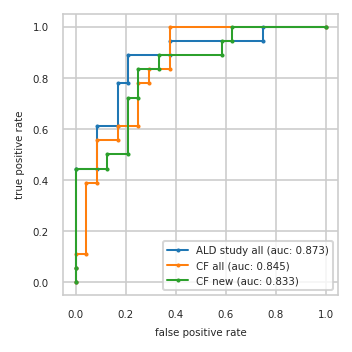

In [21]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.test, results_ald_full.name, ax)
plot_split_auc(results_model_full.test, results_model_full.name, ax)
plot_split_auc(results_model_new.test, results_model_new.name, ax)
fname = args.out_folder / 'auc_roc_curve.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Data used to plot ROC:

In [22]:
res = [results_ald_full, results_model_full, results_model_new]

auc_roc_curve = parse_roc(*res)
auc_roc_curve.to_excel(fname.with_suffix('.xlsx'))
auc_roc_curve

ALD study all       CF all       CF new      
             fpr   tpr    fpr   tpr    fpr   tpr
0          0.000 0.000  0.000 0.000  0.000 0.000
1          0.000 0.056  0.000 0.056  0.000 0.056
2          0.000 0.444  0.000 0.111  0.000 0.444
3          0.083 0.444  0.042 0.111  0.125 0.444
4          0.083 0.611  0.042 0.389  0.125 0.500
5          0.167 0.611  0.083 0.389  0.208 0.500
6          0.167 0.778  0.083 0.556  0.208 0.722
7          0.208 0.778  0.167 0.556  0.250 0.722
8          0.208 0.889  0.167 0.611  0.250 0.833
9          0.375 0.889  0.250 0.611  0.333 0.833
10         0.375 0.944  0.250 0.778  0.333 0.889
11         0.750 0.944  0.292 0.778  0.583 0.889
12         0.750 1.000  0.292 0.833  0.583 0.944
13         1.000 1.000  0.375 0.833  0.625 0.944
14           NaN   NaN  0.375 1.000  0.625 1.000
15           NaN   NaN  1.000 1.000  1.000 1.000

### Features selected for final models

In [23]:
selected_features = pd.DataFrame(
    [results_ald_full.selected_features,
     results_model_full.selected_features,
     results_model_new.selected_features],
    index=[
        results_ald_full.name,
        results_model_full.name,
        results_model_new.name]
).T
selected_features.index.name = 'rank'
fname = args.out_folder / 'mrmr_feat_by_model.xlsx'
files_out[fname.name] = fname
selected_features.to_excel(fname)
selected_features

,ALD study all,CF all,CF new
rank,,,
0,P10636-2;P10636-6,Q9Y2T3;Q9Y2T3-3,Q14894
1,P31946;P31946-2,P60709;P63261,P23560;P23560-2;P23560-3;P23560-4;P23560-5
2,P09960;P09960-4,F8WE04;P04792,J3KSJ8;Q9UD71;Q9UD71-2
3,P04075,P10636-2;P10636-6,P31321
4,P61981,A0A0A0MRJ7;P12259,Q96GD0
5,C9JF17;P05090,P04075,Q9NUQ9
6,Q6EMK4,P14174,F8WBF9;Q5TH30;Q9UGV2;Q9UGV2-2;Q9UGV2-3
7,None,Q14894,D6R956;P09936
8,None,P61981,A0A0B4J1V6


### Precision-Recall plot on test data

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/prec_recall_curve.pdf


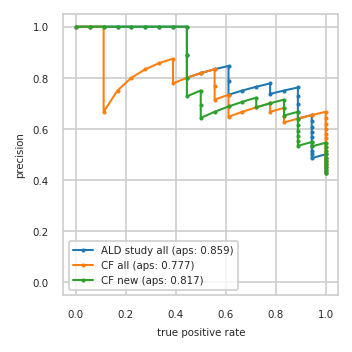

In [24]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.test, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.test, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.test, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Data used to plot PRC:

In [25]:
prec_recall_curve = parse_prc(*res)
prec_recall_curve.to_excel(fname.with_suffix('.xlsx'))
prec_recall_curve

ALD study all          CF all          CF new      
       precision   tpr precision   tpr precision   tpr
0          0.429 1.000     0.429 1.000     0.429 1.000
1          0.439 1.000     0.439 1.000     0.439 1.000
2          0.450 1.000     0.450 1.000     0.450 1.000
3          0.462 1.000     0.462 1.000     0.462 1.000
4          0.474 1.000     0.474 1.000     0.474 1.000
5          0.486 1.000     0.486 1.000     0.486 1.000
6          0.500 1.000     0.500 1.000     0.500 1.000
7          0.486 0.944     0.514 1.000     0.514 1.000
8          0.500 0.944     0.529 1.000     0.529 1.000
9          0.515 0.944     0.545 1.000     0.545 1.000
10         0.531 0.944     0.562 1.000     0.531 0.944
11         0.548 0.944     0.581 1.000     0.548 0.944
12         0.567 0.944     0.600 1.000     0.533 0.889
13         0.586 0.944     0.621 1.000     0.552 0.889
14         0.607 0.944     0.643 1.000     0.571 0.889
15         0.630 0.944     0.667 1.000     0.593 0.889
16         0.654 0.944     0.654 0.944     0.615 0.889
17         0.640 0.889     0.640 0.889     0.640 0.889
18         0.667 0.889     0.625 0.833     0.667 0.889
19         0.696 0.889     0.652 0.833     0.652 0.833
20         0.727 0.889     0.682 0.833     0.682 0.833
21         0.762 0.889     0.667 0.778     0.714 0.833
22         0.750 0.833     0.700 0.778     0.700 0.778
23         0.737 0.778     0.684 0.722     0.684 0.722
24         0.778 0.778     0.667 0.667     0.722 0.722
25         0.765 0.722     0.647 0.611     0.706 0.667
26         0.750 0.667     0.688 0.611     0.688 0.611
27         0.733 0.611     0.733 0.611     0.667 0.556
28         0.786 0.611     0.714 0.556     0.643 0.500
29         0.846 0.611     0.769 0.556     0.692 0.500
30         0.833 0.556     0.833 0.556     0.750 0.500
31         0.818 0.500     0.818 0.500     0.727 0.444
32         0.800 0.444     0.800 0.444     0.800 0.444
33         0.889 0.444     0.778 0.389     0.889 0.444
34         1.000 0.444     0.875 0.389     1.000 0.444
35         1.000 0.389     0.857 0.333     1.000 0.389
36         1.000 0.333     0.833 0.278     1.000 0.333
37         1.000 0.278     0.800 0.222     1.000 0.278
38         1.000 0.222     0.750 0.167     1.000 0.222
39         1.000 0.167     0.667 0.111     1.000 0.167
40         1.000 0.111     1.000 0.111     1.000 0.111
41         1.000 0.056     1.000 0.056     1.000 0.056
42         1.000 0.000     1.000 0.000     1.000 0.000

## Train data plots

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/prec_recall_curve_train.pdf


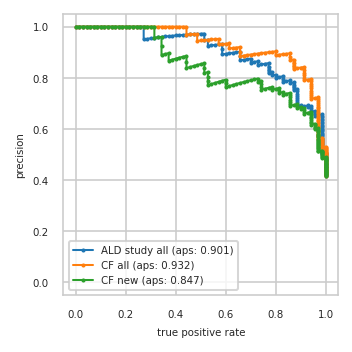

In [26]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.train, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.train, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve_train.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/auc_roc_curve_train.pdf


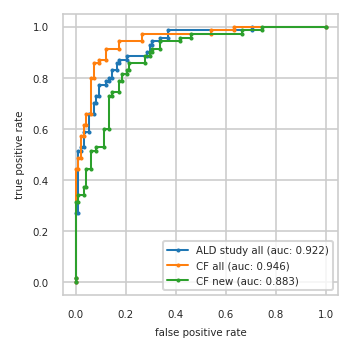

In [27]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.train, results_ald_full.name, ax)
plot_split_auc(results_model_full.train, results_model_full.name, ax)
plot_split_auc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'auc_roc_curve_train.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Output files:

In [28]:
files_out

{'results_CF all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/results_CF all.pkl'),
 'results_CF new.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/results_CF new.pkl'),
 'results_ALD study all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/results_ALD study all.pkl'),
 'auc_roc_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/auc_roc_curve.pdf'),
 'mrmr_feat_by_model.xlsx': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/mrmr_feat_by_model.xlsx'),
 'prec_recall_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/prec_recall_curve.pdf'),
 'prec_recall_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/prec_recall_curve_train.pdf'),
 'auc_roc_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/auc_roc_curve_train.pdf')}